### Importing packages here

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tqdm
import random
import pandas as pd
import pickle as pkl
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


### Loading the folder given in the task here

In [3]:
fol_dir = 'Vision_task_dataset_public/'
os.listdir(fol_dir)

['train_label.pkl',
 'train_image.pkl',
 'test_image.pkl',
 'hitkul(sample_submission).csv']

### Loading training data here

In [0]:
with open(fol_dir+'train_image.pkl', 'rb') as f:
    train_image = pkl.load(f)
with open(fol_dir+'train_label.pkl', 'rb') as f:
    train_label = pkl.load(f)

### Checking the length of the traing data

In [5]:
print(len(train_image), " ", len(train_label))

8000   8000


### Checking the dimensions of each image. Found out that each image was of dimension by taking the square root of this 28 x 28 x 1 

In [6]:
len(train_image[0])


784

### Viewing some of the sample images to see what we are dealing with

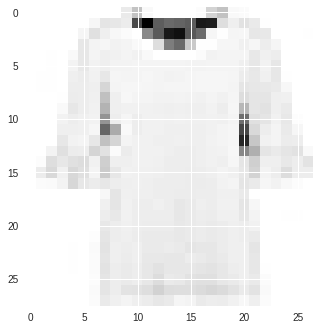

Label for the image is  6


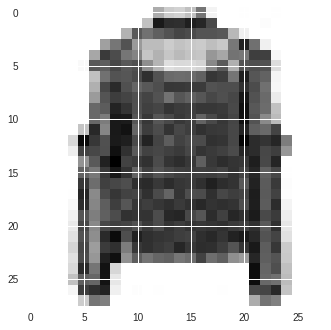

Label for the image is  6


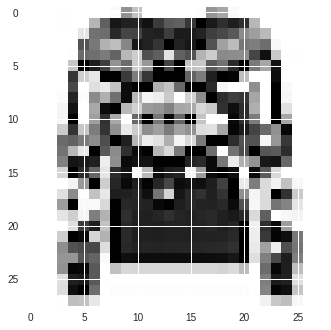

Label for the image is  2


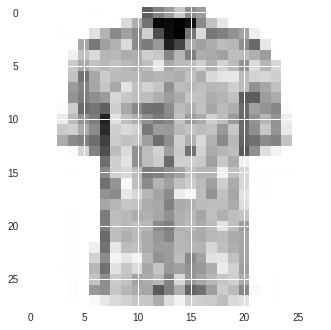

Label for the image is  6


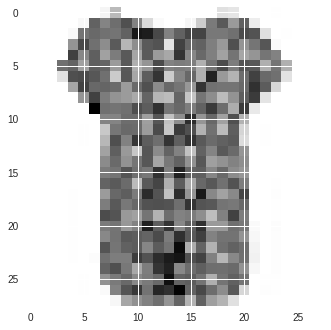

Label for the image is  6


In [7]:
rnd_lst = random.sample(range(0, 8000), 8000) # Created a list of of random numbers between 1 and 8000 which 
                                              # was used to shuffle my training data

for i in range(5):
    x = np.asarray(train_image[rnd_lst[i]])
    x = np.reshape(x, (28,28))
    plt.imshow(x); plt.show()
    print("Label for the image is ",train_label[rnd_lst[i]])

### Created different lists for X_train, y_train, X_test and y_test.....
#### Note : Here X_test and y_test are validation data taken from training data

In [0]:
X_train = []
y_train =[]
X_test =[]
y_test = []
for i in range(0, 6000):
    x = np.array(train_image[rnd_lst[i]])
    x = x/255.0
    X_train.append(x)
    y_train.append(train_label[rnd_lst[i]])

for i in range(6000, 8000):
    x = np.array(train_image[rnd_lst[i]])
    x = x/255.0
    X_test.append(x)
    y_test.append(train_label[rnd_lst[i]])



### Plotted the bargraph to count the number of samples in each category to check if it is balanced or not

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


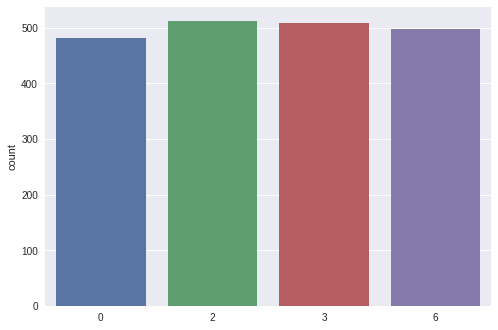

In [9]:
import seaborn as sns
g = sns.countplot(y_test)


### reshaped the samples in X_train and X_test list to 28x28x1 so that I can input them into my Convolutional Neural Network Models

### Also I changed the label "6" to "1" so that when one hot encoding, it would be easier for me.

In [0]:
for i in range(0, 6000):
    X_train[i] = X_train[i].reshape( 28, 28, 1)

for i in range(0, 2000):
    X_test[i] = X_test[i].reshape( 28, 28, 1)
  
for i in range(0, 6000):
    if(y_train[i] == 6):
        y_train[i] = 1
for i in range(0, 2000):
    if(y_test[i] == 6):
        y_test[i] = 1
  

### One hot encoded my labels here

In [0]:
y_train = to_categorical(y_train, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

### Checked the shape of my y_train

In [12]:
y_train[0].shape

(4,)

### Converted X_train and X_test to numpy arrays to input them into my CNN model

In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

### Coded my simple deep CNN model here... I didn't use complex models like resnet or vgg because of the small dimension of my training data

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(4, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Defined optimizer here and defined how I would like my model to be compiled with "categorical crossentropy" loss

In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### The below code is callback feature in keras which reduces the learning rate once the metric has stopped imporving. 

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=0.5, min_lr=0.00001)


### Initialised the number of epochs and batch size here

In [0]:
epochs = 60
batch_size = 120

### The below code helps in augmenting my sample training images. This can be changed and experimented on how it affects the training and all.

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train)


### the below checkpoint feature in keras helps me to save the best weights only for which the epoch showed minimum validation loss

In [0]:
checkpoint=ModelCheckpoint('MIDASTASKMODEL.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

### Ran the model here

In [20]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
50/50 [==============================] - 49s 980ms/step - loss: 1.0646 - acc: 0.5088 - val_loss: 0.7342 - val_acc: 0.7000
Epoch 2/60
50/50 [==============================] - 48s 954ms/step - loss: 0.8372 - acc: 0.6440 - val_loss: 0.6281 - val_acc: 0.7395
Epoch 3/60
50/50 [==============================] - 48s 957ms/step - loss: 0.7677 - acc: 0.6783 - val_loss: 0.6406 - val_acc: 0.7220
Epoch 4/60
50/50 [==============================] - 48s 952ms/step - loss: 0.7233 - acc: 0.7008 - val_loss: 0.5620 - val_acc: 0.7600
Epoch 5/60
50/50 [==============================] - 48s 960ms/step - loss: 0.6904 - acc: 0.7137 - val_loss: 0.5284 - val_acc: 0.7915
Epoch 6/60
50/50 [==============================] - 49s 974ms/step - loss: 0.6612 - acc: 0.7320 - val_loss: 0.5097 - val_acc: 0.7915
Epoch 7/60
50/50 [==============================] - 48s 961ms/step - loss: 0.6362 - acc: 0.7407 - val_loss: 0.5090 - val_acc: 0.8045
Epoch 8/60
50/50 [===

### Printed the confusion matrix to check how well the model ran and how well each individual label was predicted

In [25]:

from sklearn.metrics import confusion_matrix
from keras.models import load_model

#Loading the best model here
model1 = load_model('MIDASTASKMODEL.h5')

# Predict the values from the validation dataset
Y_pred = model1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
print(confusion_mtx)
#plot_confusion_matrix(confusion_mtx, classes = range(4)) 

[[405  49  14  14]
 [ 42 404  40  11]
 [  7  46 454   5]
 [ 12  19   4 474]]


### Plotted how training and validation loss as well as training and validation accuracy changes with each epoch to see where it went constant

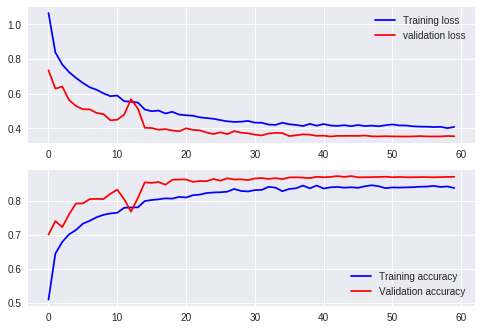

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Loaded the test data

In [0]:
with open(fol_dir+'test_image.pkl', 'rb') as f:
    test_image = pkl.load(f)


In [64]:
len(test_image)

2000

### reshaped it in the same way as I reshaped the above training and validation data

In [0]:
testX =[]
for i in range(0, 2000):
    x = np.array(test_image[i])
    x = x/255.0
    x = x.reshape( 28, 28, 1)
    testX.append(x)
testX = np.array(testX)

### predicted the test labels with the help of the best model saved

In [0]:
testy = model1.predict(testX)

### Got the index which indicates the max probability of it being the feature

In [73]:
testy_pred = []
for i in range(0, len(testy)):
    testy_pred.append(np.argmax(testy[i]))
testy_pred[:10]   

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

### plotted the images in test set and also printed out the predicted labels to check how well the model worked

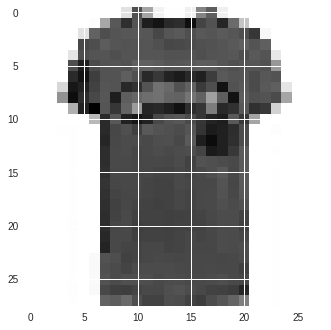

Label for the image is  0


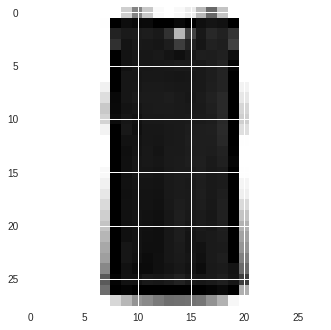

Label for the image is  0


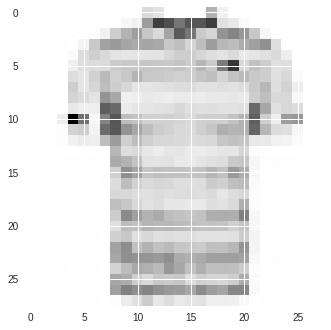

Label for the image is  0


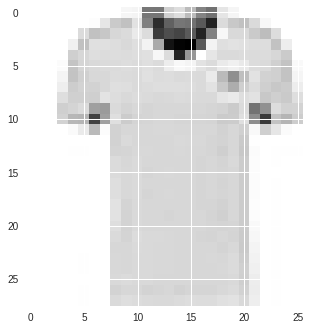

Label for the image is  0


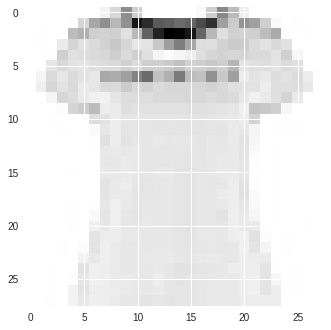

Label for the image is  0


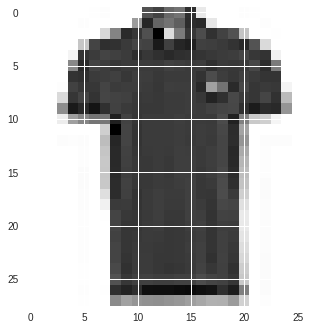

Label for the image is  0


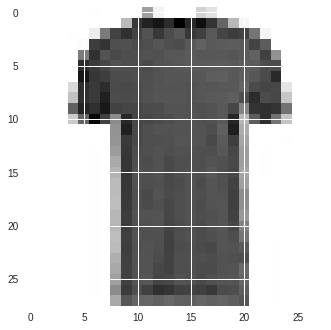

Label for the image is  0


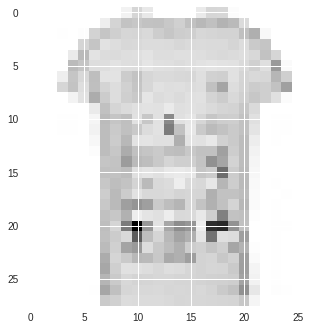

Label for the image is  0


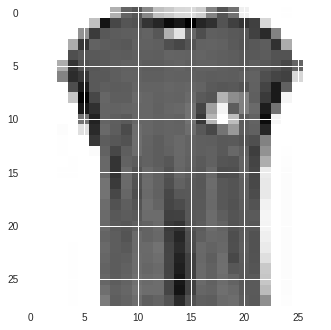

Label for the image is  1


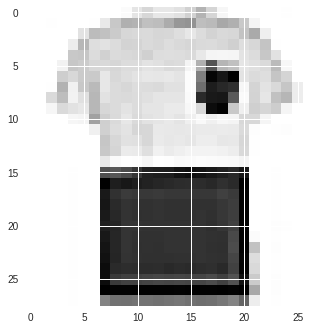

Label for the image is  0


In [74]:
with open(fol_dir+'test_image.pkl', 'rb') as f:
    test_image = pkl.load(f)
for i in range(10):
    x = np.asarray(test_image[i])
    x = np.reshape(x, (28,28))
    plt.imshow(x); plt.show()
    print("Label for the image is ",testy_pred[i])

### Here I created a list of dictionary with image index and predicted label... Also notice that I changed the label "1" to "6" since I changed it before training

In [0]:
dict_lst =[]
for i in range(0, len(testy)):
    testy_pred = np.argmax(testy[i])
    if(testy_pred == 1):
        testy_pred = 6
    dict_tmp = {'image_index':i, 'class':testy_pred}
    dict_lst.append(dict_tmp)
    

### Created a dataframe here

In [0]:
df = pd.DataFrame(dict_lst)

In [77]:
df = df[['image_index', 'class']]
df

,image_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,6
9,9,0


### Saved it to a csv with my full_name

In [0]:
df.to_csv('/content/drive/My Drive/manish_edida.csv', index = False)